In [1]:
# https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
import pandas as pd
from datetime import datetime
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import math
import matplotlib.pyplot as plt

np.random.seed(1337)

# Creating functions

In [2]:
# transform series into train and test sets for supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg


In [3]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	
    # transform data to be stationary
	diff_values = raw_values
	diff_values = diff_values.reshape(len(diff_values), 1)
	
    # rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	
    # transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	
    # split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

In [4]:
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]

    X = X.reshape(X.shape[0], 1, X.shape[1])

    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, verbose=2, shuffle=False)

    return model

In [5]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    
    # convert to array
    return [x for x in forecast[0, :]]
 
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [6]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler):
    inverted = list()
    for i in range(len(forecasts)):
        
        # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]

        inverted.append(inv_scale)

    return inverted

# Fitting and predicting

In [7]:
# load dataset
logreturns = 'data/final.csv'
series = pd.read_csv(logreturns, usecols=['Exchange.Date', 'logreturns'], header=0, index_col=0, squeeze=True)

# configure
n_lag = 1
n_seq = 100 #  number of periods forecast
n_test = int(len(series)*0.3)
n_epochs = 5
n_batch = 1
n_neurons = 50

# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler)

Epoch 1/5
3095/3095 - 4s - loss: 0.0089
Epoch 2/5
3095/3095 - 3s - loss: 0.0075
Epoch 3/5
3095/3095 - 3s - loss: 0.0074
Epoch 4/5
3095/3095 - 3s - loss: 0.0074
Epoch 5/5
3095/3095 - 3s - loss: 0.0074


# Evaluating from t=1

In [8]:
original_df = pd.read_csv('data/final.csv', usecols=['logreturns', 'Close'])
train_df = original_df[:-n_test].copy()

last_train = train_df['Close'].values[-1]
price_forecasts = np.exp(np.cumsum(forecasts[0]) + math.log(last_train))

train_df['forecast'] = train_df['Close'] # temporary until actual forecasts are added

eval_df = pd.DataFrame(columns=['Close', 'logreturns', 'forecast'])
eval_df['Close'] = original_df['Close'].values[-n_test:-n_test+n_seq]
eval_df['logreturns'] = original_df['logreturns'].values[-n_test:-n_test+n_seq]
eval_df['forecast'] = price_forecasts

merged_df = train_df.append(eval_df, ignore_index=True)
merged_df['error'] = merged_df['forecast'] - merged_df['Close']

merged_df['actual_positive'] = merged_df['Close'].diff(1) > 0
merged_df['forecast_positive'] = merged_df['forecast'].diff(1) > 0

# merged_df.tail(n_seq)

In [11]:
# RMSE and MAE
def evaluate(n_periods):
    df = merged_df[len(train_df):len(train_df)+n_periods]
    mape = np.mean(np.abs((df['error']) / df['Close'])) * 100
    rmse = math.sqrt(pow(df['error'].sum(), 2) / n_periods)
    print(f"{n_periods}, RMSE: {round(rmse, 3)}, MAPE: {round(mape, 3)}%")

evaluate(1)
evaluate(3)
evaluate(5)
evaluate(7)
evaluate(30)
evaluate(90)
evaluate(100)

1, RMSE: 2.881, MAPE: 0.569%
3, RMSE: 8.0, MAPE: 0.905%
5, RMSE: 11.045, MAPE: 0.966%
7, RMSE: 16.745, MAPE: 1.23%
30, RMSE: 45.775, MAPE: 2.366%
90, RMSE: 185.143, MAPE: 4.807%
100, RMSE: 175.886, MAPE: 4.504%


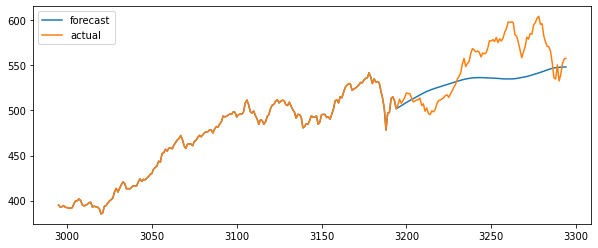

In [13]:
plot_df = merged_df[-n_seq - (n_seq*2) :]
plt.figure(figsize=(10, 4))
plt.plot(plot_df['forecast'], label="forecast")
plt.plot(plot_df['Close'], label="actual")
plt.legend()